In [60]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from collections import defaultdict

from f1optimizer import F1Optimizer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report

import lightgbm as lgb

In [3]:
cwd = os.getcwd()
order_products_train_df = pd.read_csv(cwd + '/data/order_products__train.csv')
order_products_prior_df = pd.read_csv(cwd + '/data/order_products__prior.csv')
orders_df = pd.read_csv(cwd + '/data/orders.csv')
products_df = pd.read_csv(cwd + '/data/products.csv')
products_df = products_df.drop('product_name', axis=1)
aisles_df = pd.read_csv(cwd + '/data/aisles.csv')
departments_df = pd.read_csv(cwd + '/data/departments.csv')

In [4]:
orders_df.days_since_prior_order.max()

30.0

put days since prior orders with Nan to max (30)

In [5]:
orders_df.days_since_prior_order = orders_df.days_since_prior_order.fillna(30).astype(np.uint8)

order_products_prior_df = pd.merge(orders_df, order_products_prior_df, on='order_id', how='inner')
order_products_prior_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,30,196,1,0
1,2539329,1,prior,1,2,8,30,14084,2,0
2,2539329,1,prior,1,2,8,30,12427,3,0
3,2539329,1,prior,1,2,8,30,26088,4,0
4,2539329,1,prior,1,2,8,30,26405,5,0


In [6]:
order_products_train_df = order_products_train_df.merge(orders_df[['user_id','order_id']], on = 'order_id', how = 'inner')
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108


In [7]:
reorder_df = order_products_prior_df.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
reorder_df['times_product_bought'] = reorder_df.groupby(['user_id', 'product_id']).cumcount()+1
reorder_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,times_product_bought
0,2539329,1,prior,1,2,8,30,196,1,0,1
2,2539329,1,prior,1,2,8,30,12427,3,0,1
1,2539329,1,prior,1,2,8,30,14084,2,0,1
3,2539329,1,prior,1,2,8,30,26088,4,0,1
4,2539329,1,prior,1,2,8,30,26405,5,0,1


In [8]:
bought1_df = reorder_df[reorder_df['times_product_bought'] == 1].groupby('product_id').size().to_frame('n_product_1st_order')
bought1_df['n_product_orders'] = reorder_df.groupby('product_id')['product_id'].size()
bought1_df['n_product_reorders'] = reorder_df.groupby('product_id')['reordered'].sum()
bought1_df.head()

,n_product_1st_order,n_product_orders,n_product_reorders
product_id,,,
1,716,1852,1136
2,78,90,12
3,74,277,203
4,182,329,147
5,6,15,9


In [9]:
bought2_df = reorder_df[reorder_df['times_product_bought'] == 2].groupby('product_id').size().to_frame('n_product_2nd_order')
bought2_df = bought2_df.reset_index().merge(bought1_df.reset_index())
bought2_df.head()

,product_id,n_product_2nd_order,n_product_1st_order,n_product_orders,n_product_reorders
0,1,276,716,1852,1136
1,2,8,78,90,12
2,3,36,74,277,203
3,4,64,182,329,147
4,5,4,6,15,9


In [10]:
bought2_df['product_reorder_prob'] = bought2_df.n_product_2nd_order / bought2_df.n_product_1st_order
bought2_df['product_reorder_ratio'] = bought2_df.n_product_reorders / bought2_df.n_product_orders
bought2_df.head()

,product_id,n_product_2nd_order,n_product_1st_order,n_product_orders,n_product_reorders,product_reorder_prob,product_reorder_ratio
0,1,276,716,1852,1136,0.385475,0.613391
1,2,8,78,90,12,0.102564,0.133333
2,3,36,74,277,203,0.486486,0.732852
3,4,64,182,329,147,0.351648,0.446809
4,5,4,6,15,9,0.666667,0.600000


In [11]:
keep_cols = ['product_id', 'n_product_orders', 'product_reorder_prob', 'product_reorder_ratio']
product_info_df = bought2_df[keep_cols]
del reorder_df, bought1_df, bought2_df 
product_info_df.head()

,product_id,n_product_orders,product_reorder_prob,product_reorder_ratio
0,1,1852,0.385475,0.613391
1,2,90,0.102564,0.133333
2,3,277,0.486486,0.732852
3,4,329,0.351648,0.446809
4,5,15,0.666667,0.600000


In [12]:
tmp = orders_df[orders_df['eval_set'] == 'prior'].groupby(['user_id'])
users_df = tmp.order_number.max().to_frame('n_user_orders')
users_df['user_lifetime'] = tmp.days_since_prior_order.sum().astype(np.uint16)
users_df['user_avg_days_since_prior_order'] = tmp.days_since_prior_order.mean()
del tmp
users_df.head()

,n_user_orders,user_lifetime,user_avg_days_since_prior_order
user_id,,,
1,10,206,20.600000
2,14,228,16.285714
3,12,163,13.583333
4,5,85,17.000000
5,4,70,17.500000


In [13]:
user_products_tmp_df = order_products_prior_df.groupby('user_id').size().to_frame('user_total_products')
user_products_tmp_df['n_reorders'] = order_products_prior_df[order_products_prior_df['reordered'] == 1].groupby('user_id')['product_id'].size()
user_products_tmp_df['n_possible_reorders'] = order_products_prior_df[order_products_prior_df['order_number'] > 1].groupby('user_id')['product_id'].size()
user_products_tmp_df['user_reorder_ratio'] = user_products_tmp_df.n_reorders / user_products_tmp_df.n_possible_reorders
user_products_tmp_df.drop(['n_reorders', 'n_possible_reorders'], axis = 1, inplace = True)
user_products_tmp_df['user_distinct_products'] = order_products_prior_df.groupby(['user_id'])['product_id'].nunique()
user_products_tmp_df.head()

,user_total_products,user_reorder_ratio,user_distinct_products
user_id,,,
1,59,0.759259,18
2,195,0.510989,102
3,88,0.705128,33
4,18,0.071429,17
5,37,0.538462,23


In [14]:
users_df = users_df.reset_index().merge(user_products_tmp_df.reset_index())
users_df['user_avg_basket'] = users_df.user_total_products / users_df.n_user_orders

orders_tmp_df = orders_df[orders_df['eval_set'] != 'prior']
orders_tmp_df = orders_tmp_df[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users_df = users_df.merge(orders_tmp_df)

del user_products_tmp_df, orders_tmp_df
gc.collect()

46

In [15]:
tmp = order_products_prior_df.groupby(['user_id', 'product_id'])
order_products_df = tmp.size().to_frame('n_user_product_orders')
order_products_df['user_product_1st_order'] = tmp.order_number.min()
order_products_df['user_product_last_order'] = tmp.order_number.max()
order_products_df['user_product_avg_cart_order'] = tmp.add_to_cart_order.mean()
order_products_df.reset_index().head()

,user_id,product_id,n_user_product_orders,user_product_1st_order,user_product_last_order,user_product_avg_cart_order
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333


In [16]:
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [17]:
data = order_products_df.reset_index()
data = data.merge(product_info_df, on='product_id')
data = data.merge(users_df, on='user_id')
data.head()

,user_id,product_id,n_user_product_orders,user_product_1st_order,user_product_last_order,user_product_avg_cart_order,n_product_orders,product_reorder_prob,product_reorder_ratio,n_user_orders,user_lifetime,user_avg_days_since_prior_order,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,206,20.6,59,0.759259,18,5.9,1187899,train,14
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,206,20.6,59,0.759259,18,5.9,1187899,train,14
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,206,20.6,59,0.759259,18,5.9,1187899,train,14
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,206,20.6,59,0.759259,18,5.9,1187899,train,14
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,206,20.6,59,0.759259,18,5.9,1187899,train,14


In [18]:
data['user_product_order_rate'] = data.n_user_product_orders / data.n_user_orders
data['user_product_orders_since_last_order'] = data.n_user_orders - data.user_product_last_order
data.head()

,user_id,product_id,n_user_product_orders,user_product_1st_order,user_product_last_order,user_product_avg_cart_order,n_product_orders,product_reorder_prob,product_reorder_ratio,n_user_orders,...,user_avg_days_since_prior_order,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order,user_product_order_rate,user_product_orders_since_last_order
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,...,20.6,59,0.759259,18,5.9,1187899,train,14,1.0,0
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,...,20.6,59,0.759259,18,5.9,1187899,train,14,0.9,0
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,...,20.6,59,0.759259,18,5.9,1187899,train,14,0.1,5
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,...,20.6,59,0.759259,18,5.9,1187899,train,14,1.0,0
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,...,20.6,59,0.759259,18,5.9,1187899,train,14,0.3,0


In [19]:
keep_cols = ['user_id', 'product_id', 'reordered']
data = data.merge(order_products_train_df[keep_cols], how='left', on=['user_id', 'product_id'])
data = data.merge(products_df, on='product_id')
data.head()

,user_id,product_id,n_user_product_orders,user_product_1st_order,user_product_last_order,user_product_avg_cart_order,n_product_orders,product_reorder_prob,product_reorder_ratio,n_user_orders,...,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order,user_product_order_rate,user_product_orders_since_last_order,reordered,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,...,18,5.900000,1187899,train,14,1.000000,0,1.0,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,...,13,3.272727,2161313,test,7,0.227273,0,NaN,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,...,133,22.666667,1735923,test,8,0.333333,2,NaN,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,...,102,6.212121,1854765,train,28,0.030303,23,NaN,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,...,190,14.950000,280888,test,18,0.100000,3,NaN,77,7


In [20]:
order_products_train_df = order_products_train_df[order_products_train_df.reordered == 1].drop('reordered', axis=1)

In [21]:
orders_df.set_index('order_id', drop=False, inplace=True)
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2539329,2539329,1,prior,1,2,8,30
2398795,2398795,1,prior,2,3,7,15
473747,473747,1,prior,3,3,12,21
2254736,2254736,1,prior,4,4,7,29
431534,431534,1,prior,5,4,15,28


In [22]:
train = orders_df[['order_id', 'eval_set']].loc[orders_df['eval_set'] == 'train']
train['actual'] = order_products_train_df.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train['actual'] = train['actual'].fillna('')
n_actual = train['actual'].apply(lambda x: len(x)).mean()

In [23]:
test = orders_df[['order_id', 'eval_set']].loc[orders_df['eval_set'] == 'test']
test['actual'] = ' '
train_test = pd.concat([train, test])
train_test.set_index('order_id', drop=False, inplace=True)

del orders_df, order_products_train_df, train, test
gc.collect()

14

In [24]:
train_test.head()

,order_id,eval_set,actual
order_id,,,
1187899,1187899,train,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1492625,1492625,train,"[22963, 7963, 16589, 32792, 41787, 22825, 2485..."
2196797,2196797,train,"[15349, 21413, 40706, 21616]"
525192,525192,train,"[47272, 37999, 13198, 43967, 40852, 17638, 298..."
880375,880375,train,"[15937, 23165, 21903, 41540]"


In [25]:
train_test[train_test.eval_set == 'test'].head()

,order_id,eval_set,actual
order_id,,,
2774568,2774568,test,
329954,329954,test,
1528013,1528013,test,
1376945,1376945,test,
1356845,1356845,test,


In [26]:
data.reordered = data.reordered.fillna(0).astype(np.uint8)
data.head()

,user_id,product_id,n_user_product_orders,user_product_1st_order,user_product_last_order,user_product_avg_cart_order,n_product_orders,product_reorder_prob,product_reorder_ratio,n_user_orders,...,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order,user_product_order_rate,user_product_orders_since_last_order,reordered,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,...,18,5.900000,1187899,train,14,1.000000,0,1,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,...,13,3.272727,2161313,test,7,0.227273,0,0,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,...,133,22.666667,1735923,test,8,0.333333,2,0,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,...,102,6.212121,1854765,train,28,0.030303,23,0,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,...,190,14.950000,280888,test,18,0.100000,3,0,77,7


In [27]:
train = data[data['eval_set'] == 'train'].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)
test =  data[data['eval_set'] == 'test'].drop(['eval_set', 'user_id', 'reordered'], axis=1)

check_data =  data.drop(['eval_set', 'user_id', 'reordered'], axis=1)

del data
gc.collect()

0

In [28]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=125)

del train
gc.collect()

17

got to love a good lgbm

In [29]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

In [30]:
params = {'task': 'train',
          'boosting_type': 'gbdt',   
          'objective': 'binary', 
          'metric': {'binary_logloss', 'auc'},
          'num_iterations': 1000, 
          'max_bin': 100, 
          'num_leaves': 512, 
          'learning_rate': 0.05,
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.95,
          'bagging_freq': 5, 
          'min_data_in_leaf': 200, 
          'num_threads': 4
         }

lgbm = lgb.train(params, 
                      lgb_train, num_boost_round=300, 
                      valid_sets=lgb_eval, 
                      early_stopping_rounds=10)

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.824716	valid_0's binary_logloss: 0.312129
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.827227	valid_0's binary_logloss: 0.304709
[3]	valid_0's auc: 0.82759	valid_0's binary_logloss: 0.298629
[4]	valid_0's auc: 0.827938	valid_0's binary_logloss: 0.294429
[5]	valid_0's auc: 0.82887	valid_0's binary_logloss: 0.289883
[6]	valid_0's auc: 0.829355	valid_0's binary_logloss: 0.28593
[7]	valid_0's auc: 0.82964	valid_0's binary_logloss: 0.282448
[8]	valid_0's auc: 0.829802	valid_0's binary_logloss: 0.279512
[9]	valid_0's auc: 0.830172	valid_0's binary_logloss: 0.276625
[10]	valid_0's auc: 0.83026	valid_0's binary_logloss: 0.27413
[11]	valid_0's auc: 0.830301	valid_0's binary_logloss: 0.271972
[12]	valid_0's auc: 0.830295	valid_0's binary_logloss: 0.270023
[13]	valid_0's auc: 0.830553	valid_0's binary_logloss: 0.268068
[14]	valid_0's auc: 0.830761	valid_0's binary_logloss: 0.266305
[15]	valid_0's auc: 0.830932	valid_0's binary_logloss: 0.

[129]	valid_0's auc: 0.83661	valid_0's binary_logloss: 0.24414
[130]	valid_0's auc: 0.836638	valid_0's binary_logloss: 0.244118
[131]	valid_0's auc: 0.836665	valid_0's binary_logloss: 0.244103
[132]	valid_0's auc: 0.836691	valid_0's binary_logloss: 0.244086
[133]	valid_0's auc: 0.836692	valid_0's binary_logloss: 0.244084
[134]	valid_0's auc: 0.836727	valid_0's binary_logloss: 0.244068
[135]	valid_0's auc: 0.836762	valid_0's binary_logloss: 0.244044
[136]	valid_0's auc: 0.836806	valid_0's binary_logloss: 0.244017
[137]	valid_0's auc: 0.836823	valid_0's binary_logloss: 0.244009
[138]	valid_0's auc: 0.836863	valid_0's binary_logloss: 0.243979
[139]	valid_0's auc: 0.836893	valid_0's binary_logloss: 0.243963
[140]	valid_0's auc: 0.836908	valid_0's binary_logloss: 0.243951
[141]	valid_0's auc: 0.836918	valid_0's binary_logloss: 0.243943
[142]	valid_0's auc: 0.836927	valid_0's binary_logloss: 0.243938
[143]	valid_0's auc: 0.836937	valid_0's binary_logloss: 0.243933
[144]	valid_0's auc: 0.8369

[256]	valid_0's auc: 0.838173	valid_0's binary_logloss: 0.243233
[257]	valid_0's auc: 0.838178	valid_0's binary_logloss: 0.243231
[258]	valid_0's auc: 0.838175	valid_0's binary_logloss: 0.243231
[259]	valid_0's auc: 0.838176	valid_0's binary_logloss: 0.243231
[260]	valid_0's auc: 0.838182	valid_0's binary_logloss: 0.243228
[261]	valid_0's auc: 0.838187	valid_0's binary_logloss: 0.243225
[262]	valid_0's auc: 0.838188	valid_0's binary_logloss: 0.243224
[263]	valid_0's auc: 0.838195	valid_0's binary_logloss: 0.24322
[264]	valid_0's auc: 0.838202	valid_0's binary_logloss: 0.243216
[265]	valid_0's auc: 0.838206	valid_0's binary_logloss: 0.243215
[266]	valid_0's auc: 0.838212	valid_0's binary_logloss: 0.243212
[267]	valid_0's auc: 0.838216	valid_0's binary_logloss: 0.243211
[268]	valid_0's auc: 0.838242	valid_0's binary_logloss: 0.243196
[269]	valid_0's auc: 0.838244	valid_0's binary_logloss: 0.243196
[270]	valid_0's auc: 0.838247	valid_0's binary_logloss: 0.243193
[271]	valid_0's auc: 0.838

[383]	valid_0's auc: 0.838974	valid_0's binary_logloss: 0.242778
[384]	valid_0's auc: 0.838974	valid_0's binary_logloss: 0.242778
[385]	valid_0's auc: 0.838986	valid_0's binary_logloss: 0.242771
[386]	valid_0's auc: 0.838997	valid_0's binary_logloss: 0.242767
[387]	valid_0's auc: 0.839008	valid_0's binary_logloss: 0.242763
[388]	valid_0's auc: 0.83901	valid_0's binary_logloss: 0.24276
[389]	valid_0's auc: 0.839017	valid_0's binary_logloss: 0.242756
[390]	valid_0's auc: 0.839023	valid_0's binary_logloss: 0.242754
[391]	valid_0's auc: 0.839024	valid_0's binary_logloss: 0.242754
[392]	valid_0's auc: 0.839022	valid_0's binary_logloss: 0.242755
[393]	valid_0's auc: 0.839022	valid_0's binary_logloss: 0.242755
[394]	valid_0's auc: 0.839022	valid_0's binary_logloss: 0.242756
[395]	valid_0's auc: 0.839024	valid_0's binary_logloss: 0.242755
[396]	valid_0's auc: 0.839027	valid_0's binary_logloss: 0.242754
[397]	valid_0's auc: 0.83903	valid_0's binary_logloss: 0.242753
[398]	valid_0's auc: 0.83903

[510]	valid_0's auc: 0.839622	valid_0's binary_logloss: 0.242423
[511]	valid_0's auc: 0.839621	valid_0's binary_logloss: 0.242423
[512]	valid_0's auc: 0.839622	valid_0's binary_logloss: 0.242422
[513]	valid_0's auc: 0.839625	valid_0's binary_logloss: 0.24242
[514]	valid_0's auc: 0.839632	valid_0's binary_logloss: 0.242416
[515]	valid_0's auc: 0.839633	valid_0's binary_logloss: 0.242416
[516]	valid_0's auc: 0.839632	valid_0's binary_logloss: 0.242418
[517]	valid_0's auc: 0.839642	valid_0's binary_logloss: 0.242411
[518]	valid_0's auc: 0.839643	valid_0's binary_logloss: 0.242409
[519]	valid_0's auc: 0.839642	valid_0's binary_logloss: 0.242409
[520]	valid_0's auc: 0.839642	valid_0's binary_logloss: 0.242409
[521]	valid_0's auc: 0.839645	valid_0's binary_logloss: 0.242408
[522]	valid_0's auc: 0.839647	valid_0's binary_logloss: 0.242407
[523]	valid_0's auc: 0.839644	valid_0's binary_logloss: 0.242409
[524]	valid_0's auc: 0.839645	valid_0's binary_logloss: 0.242408
[525]	valid_0's auc: 0.839

In [31]:
predictions_lgbm_prob = lgbm.predict(X_eval)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0)

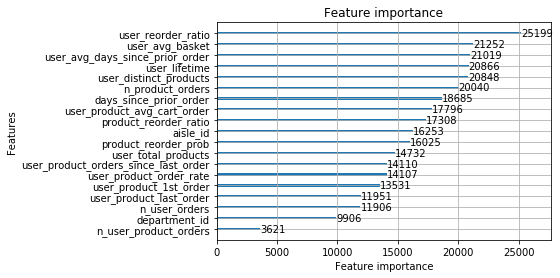

In [32]:
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

Overall accuracy of Light GBM model: 0.9108156116436882


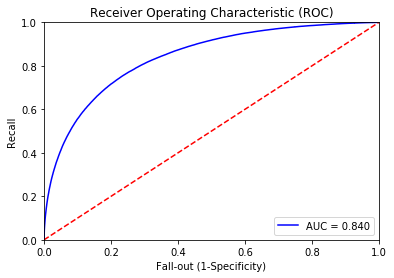

AUC score: 0.8398574376193455


<Figure size 432x288 with 0 Axes>

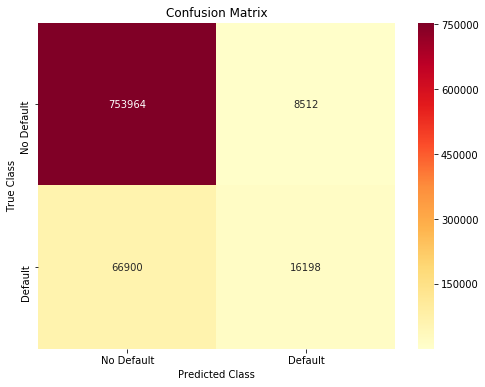

In [33]:
acc_lgbm = accuracy_score(y_eval, predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_eval, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

plt.figure()
cm = confusion_matrix(y_eval, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot = True, fmt='d', cmap="YlOrRd", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [34]:
print(classification_report(y_eval, predictions_lgbm_01))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95    762476
           1       0.66      0.19      0.30     83098

    accuracy                           0.91    845574
   macro avg       0.79      0.59      0.63    845574
weighted avg       0.89      0.91      0.89    845574



In [35]:
check_data['reordered'] = lgbm.predict(check_data[check_data.columns.difference(
    ['order_id', 'product_id'])], num_iteration=lgbm.best_iteration)

In [36]:
test_orders = train_test[train_test.eval_set == 'test'].order_id.values
test_subm_df = check_data[check_data.order_id.isin(test_orders)][['order_id', 'product_id', 'reordered']]
test_subm_df.head()

,order_id,product_id,reordered
1,2161313,196,0.636271
2,1735923,196,0.263162
4,280888,196,0.080098
10,139487,196,0.522880
16,3116687,196,0.019353


In [37]:
d = defaultdict(list)

s = test_subm_df.set_index(['order_id']).stack()
[d[k].append(v) for k, v in s.iteritems()]

test_subm_df = pd.Series(d).unstack().rename_axis(['order_id']).reset_index()
test_subm_df['product_id'] = test_subm_df['product_id'].apply(lambda x: np.array(x).astype(np.uint32))
test_subm_df['reordered'] = test_subm_df['reordered'].apply(lambda x: np.array(x))
print(test_subm_df.shape)
test_subm_df.head()

(75000, 3)


,order_id,product_id,reordered
0,17,"[47766, 16965, 39275, 13535, 21709, 38777, 703...","[0.12540082747680023, 0.07019737125241879, 0.1..."
1,34,"[13176, 7559, 35887, 47766, 21137, 44632, 4226...","[0.2709864916387995, 0.10375100611079238, 0.10..."
2,137,"[41787, 24852, 33754, 26209, 43352, 16797, 288...","[0.3571581739567427, 0.4674895732100579, 0.039..."
3,182,"[13176, 35951, 49235, 47766, 42265, 44683, 392...","[0.024920982243081525, 0.10337887082804112, 0...."
4,257,"[13176, 49235, 24852, 37646, 47766, 21137, 460...","[0.09661330970503483, 0.5483063005312451, 0.61..."


F1Optimizer.get_best_prediction implements $O(n^2)$ F1-Score expectation presented in "Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

In [62]:
test_subm_df['products'] = np.vectorize(F1Optimizer.get_best_prediction)(test_subm_df['reordered'], test_subm_df['product_id'])
test_subm_df.head()

,order_id,product_id,reordered,products
0,17,"[47766, 16965, 39275, 13535, 21709, 38777, 703...","[0.12540082747680023, 0.07019737125241879, 0.1...",13107 21463 26429
1,34,"[13176, 7559, 35887, 47766, 21137, 44632, 4226...","[0.2709864916387995, 0.10375100611079238, 0.10...",47766 16083 39475 21137 2596 43504 13176 47792...
2,137,"[41787, 24852, 33754, 26209, 43352, 16797, 288...","[0.3571581739567427, 0.4674895732100579, 0.039...",24852 23794 38689 41787 25890 2326 5134 29594
3,182,"[13176, 35951, 49235, 47766, 42265, 44683, 392...","[0.024920982243081525, 0.10337887082804112, 0....",39275 9337 5479 47672 13629 11520 41149 32109 ...
4,257,"[13176, 49235, 24852, 37646, 47766, 21137, 460...","[0.09661330970503483, 0.5483063005312451, 0.61...",24852 49235 27966 27104 37646 30233 29837 3947...


F1-Score on private leaderboard of 0.39849.  Easily could run gridsearch with lgb model to fine tune hyperparameters.  Also, the data could be engineered to add orders in the past (maybe up to last_order - 3) as previous data points in the training set

In [65]:
test_subm_df[['order_id','products']].to_csv('final_submission.csv', index=False)  